# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import SGD
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')

In [4]:
df = pd.concat([train, test])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [5]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
df.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [6]:
df.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43824 entries, 0 to 13147
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        43824 non-null  int64  
 1   DEWP      43824 non-null  float64
 2   TEMP      43824 non-null  float64
 3   PRES      43824 non-null  float64
 4   Iws       43824 non-null  float64
 5   Is        43824 non-null  float64
 6   Ir        43824 non-null  float64
 7   datetime  43824 non-null  object 
 8   cbwd_NW   43824 non-null  float64
 9   cbwd_SE   43824 non-null  float64
 10  cbwd_cv   43824 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.4+ MB


In [8]:
# Ensure 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

df['datetime'] = pd.to_datetime(df['datetime'])

# Set the 'datetime' column as the index for better time-series handling
df.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
#test.set_index('datetime', inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       43824 non-null  int64  
 1   DEWP     43824 non-null  float64
 2   TEMP     43824 non-null  float64
 3   PRES     43824 non-null  float64
 4   Iws      43824 non-null  float64
 5   Is       43824 non-null  float64
 6   Ir       43824 non-null  float64
 7   cbwd_NW  43824 non-null  float64
 8   cbwd_SE  43824 non-null  float64
 9   cbwd_cv  43824 non-null  float64
 10  pm2.5    28755 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 4.0 MB


In [10]:
df.head()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,,
2010-01-01 00:00:00,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


In [11]:
df.isnull().sum()

,0
No,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0


In [12]:
unused_cols=['No']
df.drop(columns=unused_cols,inplace=True)

In [13]:
df.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,
2010-01-01 00:00:00,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 01:00:00,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 02:00:00,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 03:00:00,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN
2010-01-01 04:00:00,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,NaN


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [14]:
df.isnull().sum()


,0
DEWP,0
TEMP,0
PRES,0
Iws,0
Is,0
Ir,0
cbwd_NW,0
cbwd_SE,0
cbwd_cv,0
pm2.5,15069


In [15]:
df.fillna(df.mean(), inplace=True)


In [16]:
df.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
datetime,,,,,,,,,,
2010-01-01 00:00:00,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 01:00:00,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 02:00:00,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 03:00:00,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427
2010-01-01 04:00:00,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427


#Visualize daily PM2.5 over entire time span

Purpose of Visualizing Daily PM2.5 Trends Over Time
This visualization helps us understand air pollution patterns in Beijing by analyzing PM2.5 concentration levels over the entire dataset's time span.

Why is this important?
Identifying Trends:

We can observe long-term increases or decreases in pollution levels.
Seasonal variations (e.g., higher pollution in winter due to heating emissions).
Detecting Anomalies:

Sudden spikes may indicate extreme pollution events like sandstorms or industrial emissions surges.
Understanding Data Seasonality:

Some periods may show regular cycles (e.g., lower PM2.5 in summer, higher in winter).
Helps in designing time-series forecasting models (LSTMs) by incorporating seasonality.
Preprocessing for Modeling:

Identifies missing values or outliers in PM2.5 concentrations.
Averages PM2.5 values per day, reducing noise from hourly fluctuations.

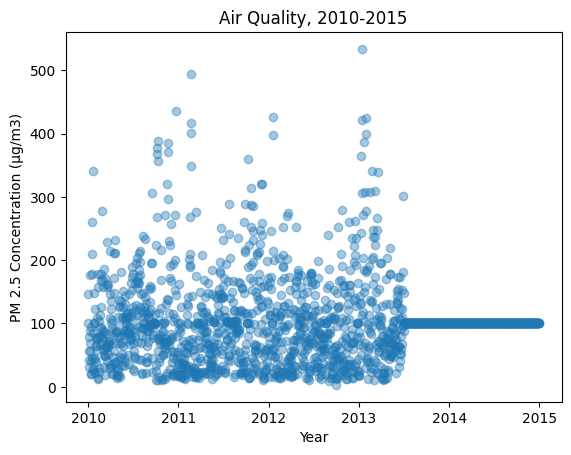

In [17]:
# Generate a simple scatter plot of daily mean PM2.5 concentration for the entire time span
scatter_y = df['pm2.5'].resample('D').mean()  # Use the correct column name
scatter_x = scatter_y.index  # The index will automatically contain the date after resampling

plt.scatter(x = scatter_x, y = scatter_y, alpha = 0.4)
plt.xlabel('Year')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality, 2010-2015')
plt.show()


#Visualize distribution of PM2.5

To visualize the distribution of PM2.5 concentrations, you can use a histogram and a kernel density estimation (KDE) plot. These plots help analyze how the values are spread across different concentration levels and detect skewness, outliers, or unusual patterns.

📌 Why is this important?
Helps understand whether the data is normally distributed or skewed (e.g., heavy pollution days).
Identifies outliers that may affect model performance.
Assists in deciding on data transformations (e.g., log transformation) to stabilize variance.
Useful for handling extreme values in predictive models.

How to Interpret the Plot?
A right-skewed distribution suggests extreme pollution days.
A peak in lower values indicates that most days have good air quality.
Multiple peaks might mean seasonal variations in pollution levels.

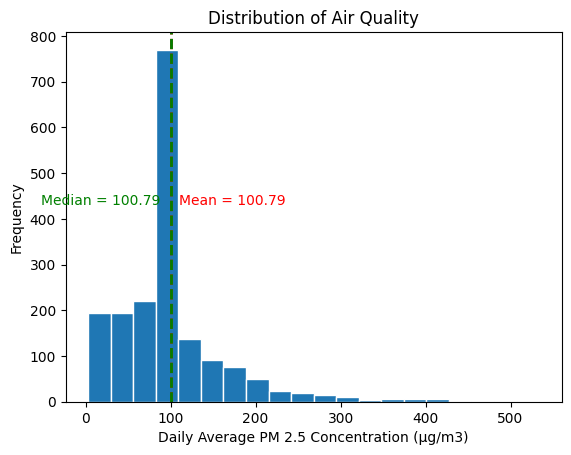

In [18]:
# Resample data to get daily mean of PM2.5
scatter_y = df['pm2.5'].resample('D').mean()  # Make sure 'pm2.5' is the correct column name

# Distribution of air quality for the period 2010-2015
plt.figure()
plt.hist(scatter_y.dropna(), bins=20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')

# Add text for mean and median
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(), 2)), color='red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(), 2)), color='green')

# Add vertical lines for mean and median
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)

plt.show()


##Visualize proportion of days characterized by each PM2.5 classification

Visualizing the Proportion of Days by PM2.5 Classification
📌 Why is this Important?
Helps categorize air quality into meaningful groups (e.g., Good, Moderate, Unhealthy).
Provides insights into how frequently different pollution levels occur.
Useful for policymakers and environmental analysts to monitor air quality trends.
How to Interpret the Pie Chart?
The largest section indicates the most common air quality level.
If "Unhealthy" or worse categories make up a significant proportion, it suggests frequent pollution problems.
A balanced distribution could indicate seasonal pollution variations.

Text(0.5, 1.0, 'Percentage of Days Within Each Air Quality Classification')

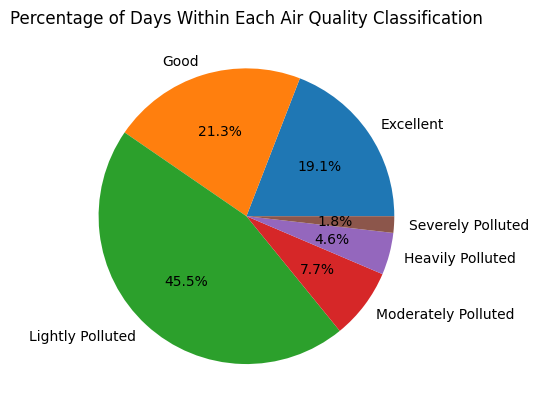

In [19]:
# Generate a pie chart to show portion of days falling into each air quality classification
excellent = len([ii for ii in scatter_y.dropna() if ii <= 50])
good = len([ii for ii in scatter_y.dropna() if ii > 50 and ii <= 100])
lightly = len([ii for ii in scatter_y.dropna() if ii > 100 and ii <= 150])
moderately = len([ii for ii in scatter_y.dropna() if ii > 150 and ii <= 200])
heavily = len([ii for ii in scatter_y.dropna() if ii > 200 and ii <= 300])
severely = len([ii for ii in scatter_y.dropna() if ii > 300])
sizes = [excellent, good, lightly, moderately, heavily, severely]
labels = ['Excellent','Good','Lightly Polluted','Moderately Polluted','Heavily Polluted','Severely Polluted']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Days Within Each Air Quality Classification')

#Visualize PM2.5 by month

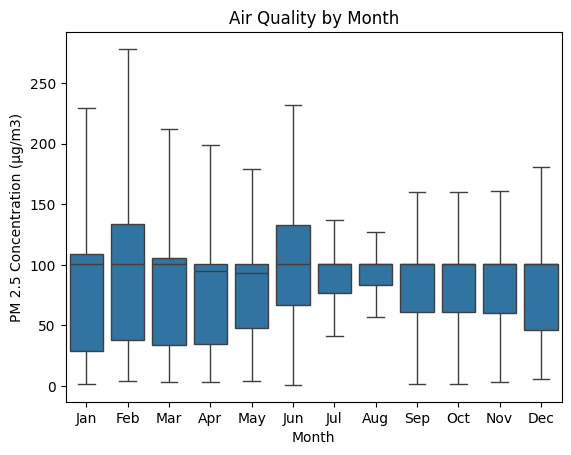

In [20]:
import calendar  # Import calendar module

# Ensure 'datetime' is the index and it is in the proper format
df.index = pd.to_datetime(df.index)

# Create a new column for the month extracted from the datetime index
df['month'] = df.index.month

# Plot PM 2.5 level by MONTH
plt.figure()
sns.boxplot(x="month", y="pm2.5", data=df, showfliers=False)  # Use correct 'pm2.5' column name
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')

# Set x-ticks to display month abbreviations
plt.xticks(range(0, 12), calendar.month_abbr[1:13])
plt.show()


#Visualize PM2.5 by day of the week

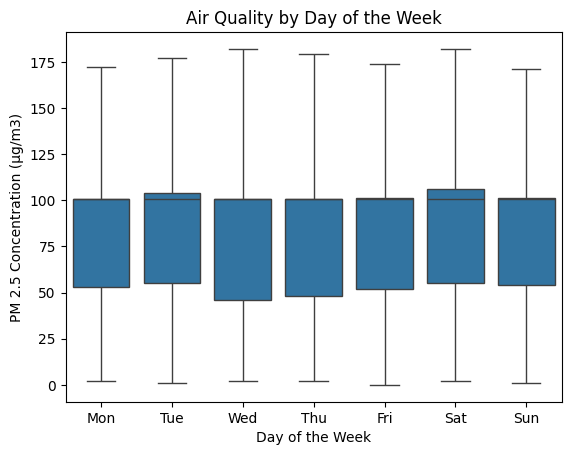

In [21]:
import calendar  # Import calendar module

# Ensure 'datetime' is the index and it is in the proper format
df.index = pd.to_datetime(df.index)

# Create a new column for the day of the week extracted from the datetime index
df['weekday'] = df.index.weekday  # Monday=0, Sunday=6

# Plot PM 2.5 level by Day of the Week
plt.figure()
sns.boxplot(x="weekday", y="pm2.5", data=df, showfliers=False)  # Use correct 'pm2.5' column name
plt.xlabel('Day of the Week')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day of the Week')

# Set x-ticks to display day names
plt.xticks(range(0, 7), calendar.day_abbr)  # Using calendar's abbreviated day names (Mon-Sun)
plt.show()


#Visualize PM2.5 by hour of the day

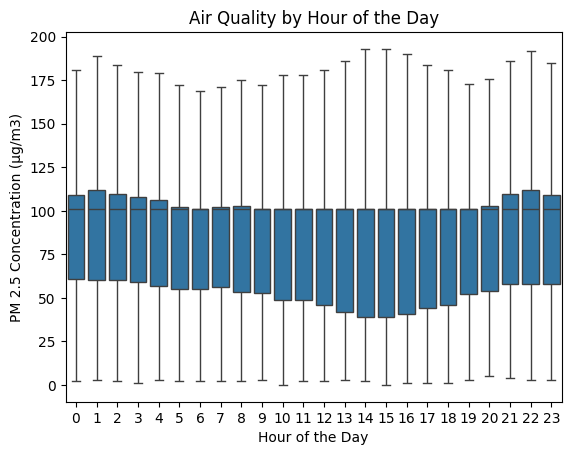

In [22]:
import calendar  # Import calendar module

# Ensure 'datetime' is the index and it is in the proper format
df.index = pd.to_datetime(df.index)

# Create a new column for the hour of the day extracted from the datetime index
df['hour'] = df.index.hour  # Extracts the hour from the datetime index

# Plot PM 2.5 level by Hour of the Day
plt.figure()
sns.boxplot(x="hour", y="pm2.5", data=df, showfliers=False)  # Use correct 'pm2.5' column name
plt.xlabel('Hour of the Day')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Hour of the Day')

# Set x-ticks to display hours from 0 to 23
plt.xticks(range(0, 24))
plt.show()


#Perform univariate analysis for all weather features

 Why is This Important?
Univariate analysis examines each variable individually to understand its distribution, central tendency, and variability. For weather features, this helps:

Detect outliers and anomalies (e.g., extreme temperatures, unusual humidity levels).
Understand the range and distribution of each feature.
Identify trends and patterns in the data.
Guide feature engineering for predictive modeling.

Text(0.5, 1.0, 'Air Quality vs. Temperature')

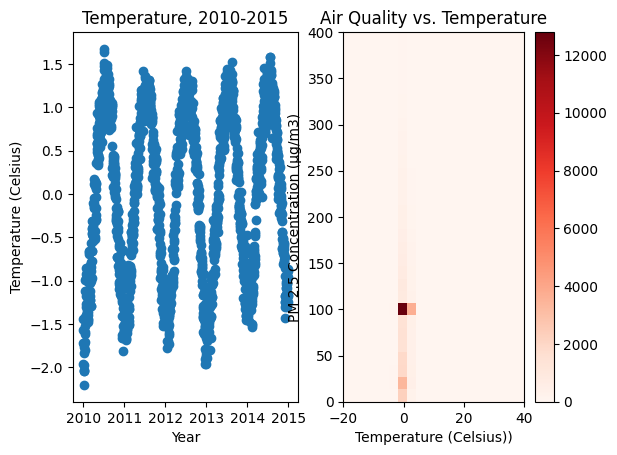

In [23]:
# Now we take a look at the other features apart from air concentration:

# Temperature

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.TEMP.resample('D').mean().index, y = df.TEMP.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.TEMP, y = df['pm2.5'], bins = (20, 30), range = ((-20,40),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Temperature (Celsius))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Temperature')

Text(0.5, 1.0, 'Air Quality vs. Pressure')

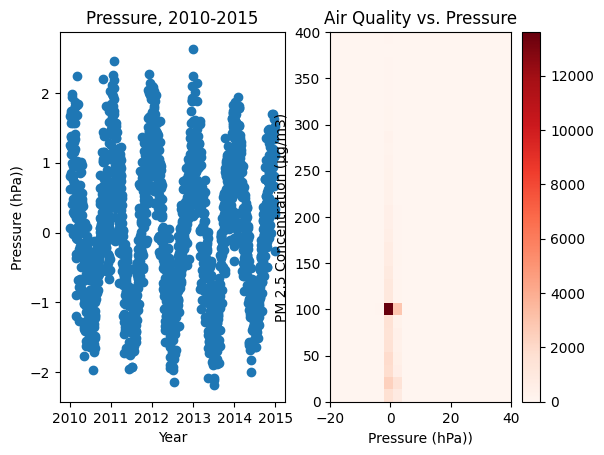

In [24]:
# Now we take a look at the other features apart from air concentration:

# Pressure

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.PRES.resample('D').mean().index, y = df.PRES.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Pressure (hPa))')
plt.title('Pressure, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.PRES, y = df['pm2.5'], bins = (20, 30), range = ((-20,40),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Pressure (hPa))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Pressure')

Text(0.5, 1.0, 'Air Quality vs. Humidity')

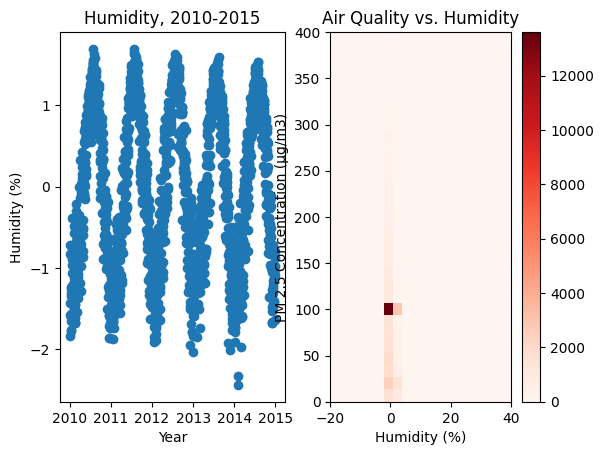

In [25]:
# Now we take a look at the other features apart from air concentration:

# Humidity

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.DEWP.resample('D').mean().index, y = df.DEWP.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Humidity (%)')
plt.title('Humidity, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.PRES, y = df['pm2.5'], bins = (20, 30), range = ((-20,40),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Humidity (%)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Humidity')

##Correlation Matrix

A correlation matrix helps identify relationships between different features in your dataset. It shows how strongly each variable is related to another using correlation coefficients.

This is important because:
✅ It helps detect highly correlated features, which might introduce redundancy in the model.
✅ It identifies potential predictor-target relationships, guiding feature selection.
✅ It can reveal unexpected dependencies between variables.

What to Look For?

Strong correlations with PM2.5 → Important predictors.
Multicollinearity (high correlations between independent features) → May cause instability in models.
Negative correlations → Features that move in opposite directions.

             DEWP      TEMP      PRES       Iws        Is        Ir   cbwd_NW  \
DEWP     1.000000  0.824633 -0.778346 -0.296399 -0.034410  0.125090 -0.337858   
TEMP     0.824633  1.000000 -0.826690 -0.154623 -0.092601  0.049121 -0.270293   
PRES    -0.778346 -0.826690  1.000000  0.185355  0.069028 -0.079843  0.229754   
Iws     -0.296399 -0.154623  0.185355  1.000000  0.021883 -0.010122  0.358815   
Is      -0.034410 -0.092601  0.069028  0.021883  1.000000 -0.009548 -0.022347   
Ir       0.125090  0.049121 -0.079843 -0.010122 -0.009548  1.000000  0.034362   
cbwd_NW -0.337858 -0.270293  0.229754  0.358815 -0.022347  0.034362  1.000000   
cbwd_SE  0.278151  0.311804 -0.250940 -0.079706  0.039963 -0.040180 -0.505490   
cbwd_cv  0.090622 -0.004743 -0.021696 -0.226972 -0.014557 -0.018725 -0.360530   
pm2.5    0.175671 -0.032510 -0.088578 -0.212758  0.020262 -0.045488 -0.188464   

          cbwd_SE   cbwd_cv     pm2.5  
DEWP     0.278151  0.090622  0.175671  
TEMP     0.311804 -0.004743 

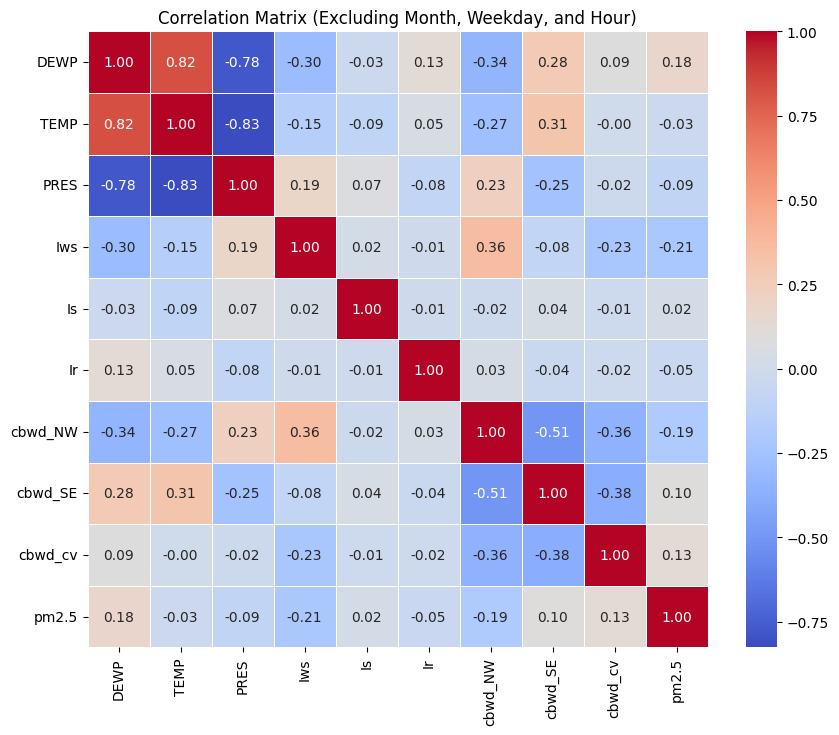

In [26]:
# Drop the 'month', 'weekday', and 'hour' columns if they exist
df_no_time = df.drop(columns=['month', 'weekday', 'hour'])

# Calculate the correlation matrix
correlation_matrix = df_no_time.corr()

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Excluding Month, Weekday, and Hour)')
plt.show()


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [27]:
df.head()

# Check if 'pm2.5' exists in df
if 'pm2.5' in df.columns:
    y_train = df['pm2.5']  # Target variable
    X_train = df.drop(columns=['pm2.5'])  # Features (all columns except 'pm2.5')
else:
    print("Error: 'pm2.5' column not found in df")
# X_train = df.drop(['pm2.5'], axis=1)
# y_train = train['pm2.5']

# Separate target and features
# target = df['pm2.5']
# X_train = df  # Your features
# y_train = target  # Your target


In [28]:
df.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,month,weekday,hour
datetime,,,,,,,,,,,,,
2010-01-01 00:00:00,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,0
2010-01-01 01:00:00,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,1
2010-01-01 02:00:00,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,2
2010-01-01 03:00:00,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,3
2010-01-01 04:00:00,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,4


In [29]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

In [30]:
df.head()

,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,month,weekday,hour
datetime,,,,,,,,,,,,,
2010-01-01 00:00:00,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,0
2010-01-01 01:00:00,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,1
2010-01-01 02:00:00,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,2
2010-01-01 03:00:00,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,3
2010-01-01 04:00:00,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,1.448138,-0.732019,-0.522096,100.793427,1,4,4


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [31]:
#define model
model_5 = Sequential()
model_5.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_5.add(LSTM(32, activation='relu', return_sequences=True))  # Keep return_sequences=True to pass sequences
model_5.add(LSTM(16, activation='relu', return_sequences=False))  # Last LSTM should have return_sequences=False
model_5.add(Dense(1))


 # Compile the model
model_5.compile(
     optimizer=Adam(learning_rate=0.002),
     loss='mse',
     metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
 )

# Display the model architecture
model_5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 64)               │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,281 (137.82 KB)

 Trainable params: 35,281 (137.82 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Early stopping to monitor validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,  # Stop if no improvement after 10 epochs
    restore_best_weights=True
)

# Train the model
# You can adjust the number of epochs and batch size to improve performance.
history = model_5.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping]  # Include early stopping
)

Epoch 1/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - lambda: 84.6000 - loss: 7866.0967
Epoch 2/30
 70/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lambda: 63.9214 - loss: 4221.3486

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: lambda,loss
  current = self.get_monitor_value(logs)


685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 63.8660 - loss: 4245.3467
Epoch 3/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 61.6421 - loss: 3980.9609
Epoch 4/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 60.2540 - loss: 3771.9209
Epoch 5/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 58.6599 - loss: 3571.8171
Epoch 6/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - lambda: 58.3902 - loss: 3526.2485
Epoch 7/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lambda: 58.3032 - loss: 3533.4834
Epoch 8/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - lambda: 58.5401 - loss: 3562.8486
Epoch 9/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 58.1289 - loss: 3506.7515
Epoch 10/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 58.5549 - loss: 3591.1399
Epoch 11/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - lambda: 58.4054 - loss: 3570.7805
Epoch 12/30
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lambda: 57.6536 - loss: 3454.8865
Epoch 13/30
685/685 ━━━━━━━━━━━━━━━━━━━━

1370/1370 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


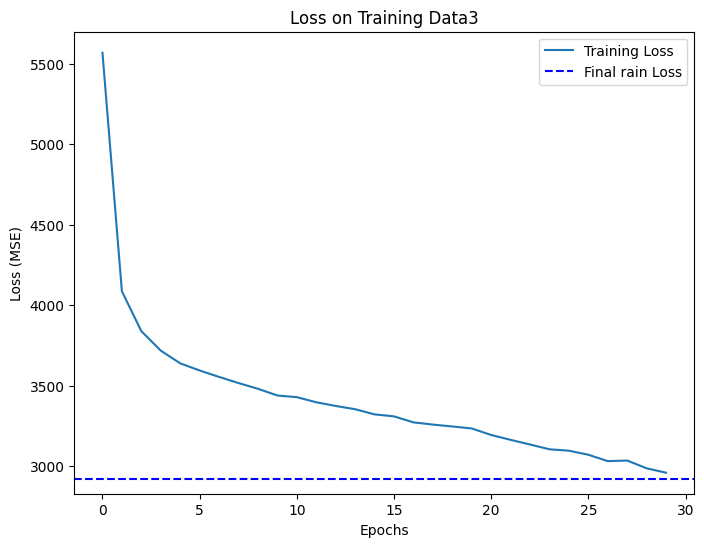

Final Training Loss (MSE): 2918.0145375689285
final raining loss (RMSE):54.0186499050923


In [33]:
# Calculate training loss
train_predictions = model_5.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)
train_loss_RSME = np.sqrt(train_loss)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data3')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"final raining loss (RMSE):{train_loss_RSME}")

Shape of X_test: (43824, 12)
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Shape of predictions: (43824, 1), Shape of y_true: (43824,)
Mean Squared Error (MSE): 2918.04
Root Mean Squared Error (RMSE): 54.02
R² (Coefficient of Determination): 0.49


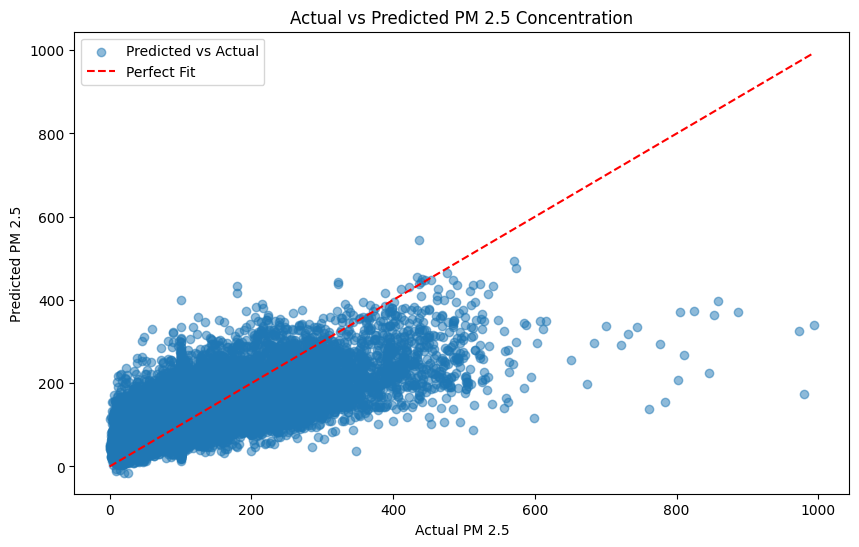

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the test data
X_test = df.drop(columns=['pm2.5'])  # Keep df unchanged (drop 'pm2.5' column)
y_true = df['pm2.5'].values  # Keep actual values for evaluation

# Check shape of X_test to ensure it aligns with model expectations
print(f"Shape of X_test: {X_test.shape}")

# Expand dimensions only if required by your model (ensure it's in the correct shape)
X_test = np.expand_dims(X_test, axis=1)  # Adjust if model requires this

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model_5.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers (if required)
predictions = np.round(predictions).astype(int)

# Check the shape of predictions and actual values
print(f"Shape of predictions: {predictions.shape}, Shape of y_true: {y_true.shape}")

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(df.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Convert to string format
    'pm2.5': predictions.flatten()  # Flatten predictions to match the expected shape
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Assement/subm_fixed5.csv', index=False)

# Calculate evaluation metrics if actual values exist
if y_true is not None and predictions is not None:
    # Calculate MSE, RMSE, and R²
    mse = mean_squared_error(y_true, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, predictions)

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R² (Coefficient of Determination): {r2:.2f}")

    # Visualize Actual vs Predicted Values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, predictions, alpha=0.5, label="Predicted vs Actual")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label="Perfect Fit")  # Line of perfect prediction
    plt.xlabel('Actual PM 2.5')
    plt.ylabel('Predicted PM 2.5')
    plt.title('Actual vs Predicted PM 2.5 Concentration')
    plt.legend()
    plt.show()

    # Visualize Residuals (Errors)
    residuals = y_true - predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted PM 2.5')
    plt.ylabel('Residuals (Error)')
    plt.title('Residuals of the Predictions')
    plt.show()

    # Check if RMSE is acceptable based on a threshold
    acceptable_rmse_threshold = 50  # Adjust based on domain knowledge
    if rmse < acceptable_rmse_threshold:
        print("✅ Model performance is acceptable.")
    else:
        print("❌ Model performance is not acceptable. Consider improving the model.")
else:
    print("⚠️ 'pm2.5' column not found in test dataset. Cannot compute metrics.")
